In [ ]:
!pip install transformers sentencepiece spacy
!pip install -U kaleido
!pip install Datasets

In [5]:
import plotly.express as px
import sys
import os
import sklearn
import tokenizers
from tqdm import trange
import tensorflow as tf
from transformers import TFAutoModel, AutoConfig, AutoTokenizer
import pandas as pd, numpy as np
from IPython.display import Image
import warnings
from tqdm import tqdm
from datasets import Dataset
tqdm.pandas()
warnings.filterwarnings("ignore")
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})


In [158]:
tf.keras.mixed_precision.set_global_policy('float32')

In [4]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.111.178.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.111.178.178:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [78]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=1000, test_split=0.2)

In [25]:
len_list = [len(i) for i in x_train]

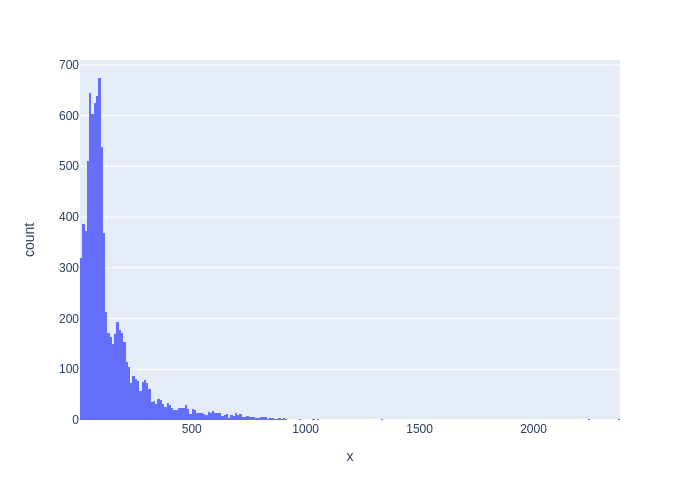

In [29]:
fig = px.histogram(x=len_list)
Image(fig.to_image())

In [30]:
np_len = np.array(len_list)

In [19]:
word_index = tf.keras.datasets.reuters.get_word_index()

In [20]:
index_word = {index:word for word,index in word_index.items()}

In [21]:
index_word[3]

'to'

In [22]:
index_word[2] = "<unk>"
index_word[1] = '<pad>'
index_word[0] = '<sos>'

In [58]:
MAX_LEN = np.percentile(np_len,95)
MAX_LEN = MAX_LEN.astype(np.int32)

In [69]:
MAX_LEN

459

In [89]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,maxlen=MAX_LEN)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,maxlen=MAX_LEN)

In [90]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [91]:
AUTO = tf.data.AUTOTUNE

In [163]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [100]:
vocab_size = 1000
embedding_dim = 128
hidden_units = 128
num_classes = 46
BATCH_SIZE = 256 * 8

In [165]:
train_ds = train_ds.repeat().shuffle(2048).batch(BATCH_SIZE,drop_remainder=True,num_parallel_calls=AUTO).prefetch(AUTO)
test_ds = test_ds.repeat().shuffle(2048).batch(BATCH_SIZE,drop_remainder=True,num_parallel_calls=AUTO).prefetch(AUTO)

In [169]:
dis_train_ds = strategy.experimental_distribute_dataset(train_ds)
dis_test_ds = strategy.experimental_distribute_dataset(test_ds)

In [ ]:
with strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
    model.add(tf.keras.layers.LSTM(hidden_units,),)
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(dis_train_ds, epochs=50, callbacks=[es, mc], validation_data=(dis_test_ds),steps_per_epoch=int(len(x_train)/BATCH_SIZE)*2
,validation_steps=int(len(x_test)/BATCH_SIZE)*2,)

In [178]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

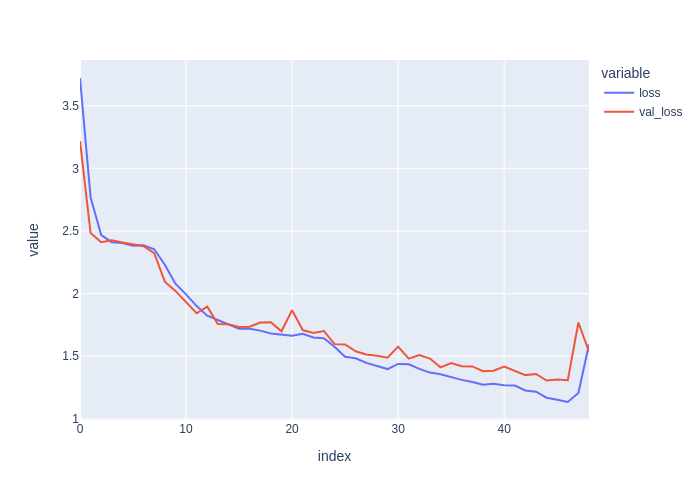

In [184]:
fig = px.line(history.history , y=["loss","val_loss",])
Image(fig.to_image())

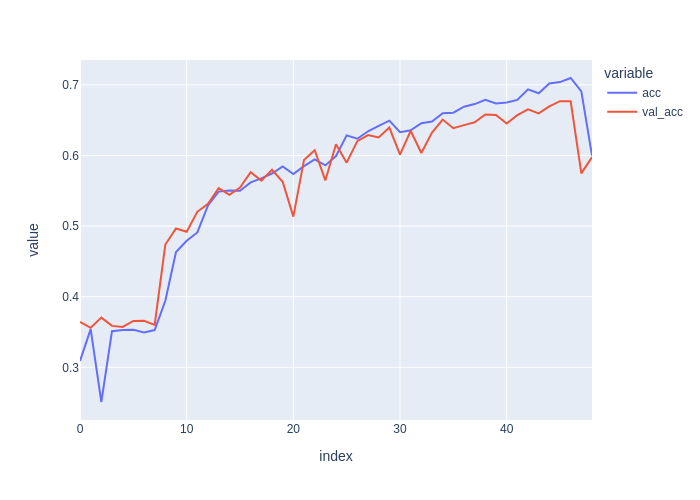

In [183]:
fig = px.line(history.history , y=["acc","val_acc",])
Image(fig.to_image())

459

In [190]:
with strategy.scope():
    input = tf.keras.Input(shape=(MAX_LEN,))
    x = tf.keras.layers.Embedding(vocab_size,embedding_dim)(input)
    x = tf.keras.layers.LSTM(128)(x)
    y = tf.keras.layers.Dense(num_classes,activation="softmax")(x)
    MODEL = tf.keras.Model(inputs=input,outputs=y)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    MODEL.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = MODEL.fit(dis_train_ds, epochs=100, callbacks=[es, mc], validation_data=(dis_test_ds),steps_per_epoch=int(len(x_train)/256)
,validation_steps=int(len(x_test)/256),)

Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 2.7817 - acc: 0.3427
Epoch 1: val_acc did not improve from 0.68164
35/35 [==============================] - 7s 94ms/step - loss: 2.7817 - acc: 0.3427 - val_loss: 2.4146 - val_acc: 0.3629
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 2.3198 - acc: 0.3821
Epoch 2: val_acc did not improve from 0.68164
35/35 [==============================] - 2s 61ms/step - loss: 2.3198 - acc: 0.3821 - val_loss: 2.0955 - val_acc: 0.4885
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 2.0161 - acc: 0.5005
Epoch 3: val_acc did not improve from 0.68164
35/35 [==============================] - 2s 62ms/step - loss: 2.0161 - acc: 0.5005 - val_loss: 1.9684 - val_acc: 0.5222
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 2.0423 - acc: 0.4598
Epoch 4: val_acc did not improve from 0.68164
35/35 [==============================] - 2s 61ms/step - loss: 2.0423 - acc: 0.4598 - val_loss: 2